# Import Necessary Modules

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the 'Food-11' Dataset & Examine It
Download the Food-11 dataset from https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [2]:
# Read the image paths
train_img_paths = [os.path.join("Dataset\\training", img)
                   for img in os.listdir("Dataset\\training")]
val_img_paths = [os.path.join("Dataset\\validation", img)
                 for img in os.listdir("Dataset\\validation")]
test_img_paths = [os.path.join("Dataset\\test", img)
                  for img in os.listdir("Dataset\\test")]

num_classes = 11

print("No. of classes: ", num_classes)
print("No. of training images: ", len(train_img_paths))
print("No. of validation images: ", len(val_img_paths))
print("No. of test images: ", len(test_img_paths))

No. of classes:  11
No. of training images:  9866
No. of validation images:  3430
No. of test images:  3347


In [3]:
# Create class labels
train_labels = [int(img.split("\\")[-1].split("_")[0])
                for img in train_img_paths]
val_labels = [int(img.split("\\")[-1].split("_")[0]) for img in val_img_paths]
test_labels = [int(img.split("\\")[-1].split("_")[0])
               for img in test_img_paths]

# Convert class labels in one hot encoded vector
train_labels_encoded = np_utils.to_categorical(train_labels, num_classes)
val_labels_encoded = np_utils.to_categorical(val_labels, num_classes)
test_labels_encoded = np_utils.to_categorical(test_labels, num_classes)

Training data available in 11 classes
[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]


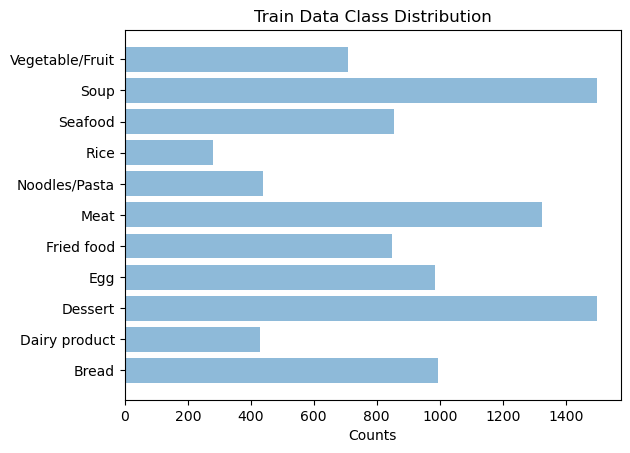

In [4]:
# Training data class distribution
print('Training data available in 11 classes')
counts = [train_labels.count(i) for i in range(0,11)]
print(counts)

food_classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat',
                'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit')

y_pos = np.arange(len(food_classes))

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')
plt.show()

In [5]:
# Validation & test data class distributions
print('Validation data available in 11 classes')
print([val_labels.count(i) for i in range(0,11)])
print()
print('Test data available in 11 classes')
print([test_labels.count(i) for i in range(0,11)])

Validation data available in 11 classes
[362, 144, 500, 327, 326, 449, 147, 96, 347, 500, 232]

Test data available in 11 classes
[368, 148, 500, 335, 287, 432, 147, 96, 303, 500, 231]


# Feature Extraction From VGG16

In [6]:
# Load the VGG16 pre-trained model without the top FC layers
model = VGG16(input_shape=(224, 224, 3),
              include_top=False,
              weights="imagenet")

# Print a summary of our model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
# Define a function that will extract features of each image in the dataset using a pre-trained model
def extract_features(dataset, pretrained_model):
    
    # Define an array that will store a list of preprocessed images
    preprocessed_images = []
 
    # Loop over the images
    for image_path in dataset: 
        # Load the input image 
        image = load_img(image_path, target_size=(224, 224))
        # Resize it to 224x224 pixels
        image = img_to_array(image)
        # Expand image dimensions
        image = np.expand_dims(image, axis=0)
        # Perform the necessary preprocessing as required by VGG16 model
        image = preprocess_input(image)
        # Add the image to the batch
        preprocessed_images.append(image)

    # Stack the sequence of images vertically inorder to make a single array
    preprocessed_images = np.vstack(preprocessed_images)
    # Extract features from the last layer of the pre-trained model
    features = pretrained_model.predict(preprocessed_images, batch_size=32)
    # Flatten the extracted features
    features_flattened = features.reshape((features.shape[0], 7 * 7 * 512))
    return preprocessed_images, features, features_flattened

In [8]:
# Extract features for each image in training, validation & test datasets using the pre-trained VGG16 model
train_images, train_features, train_features_flattened = extract_features(train_img_paths, model)
val_images, val_features, val_features_flattened = extract_features(val_img_paths, model)
test_images, test_features, test_features_flattened = extract_features(test_img_paths, model)

# Transfer Learning Using Extracted Features

## Using a Shallow Neural Network Model

### Build the Model

In [9]:
# Initalize the model using Sequential class from Keras
nn_model = Sequential()
# Add a pooling layer which will downsample our data
nn_model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
# Add a droput layer which will aid in regularization
nn_model.add(Dropout(0.2))
# Add a dense/FC layer
nn_model.add(Dense(100, activation='relu'))
# Add a dense/FC layer
nn_model.add(Dense(11, activation='softmax'))
# Compile the model
nn_model.compile(loss='categorical_crossentropy', 
                       optimizer=Adam(),
                       metrics=['accuracy'])
# Print a summary of our model
print(nn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               51300     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 52,411
Trainable params: 52,411
Non-trainable params: 0
_________________________________________________________________
None


### Define Callbacks

In [10]:
# Define a callback for saving only the best model during the training
checkpoint = ModelCheckpoint(filepath="./Trained Models/food11_nn_classifier.h5",
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training when validation accuracy has stopped increasing
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode='max',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# Put our callbacks into a list
callbacks = [earlystop, checkpoint]

### Train the Model

In [11]:
nn_model_train_result = nn_model.fit(x=train_features,
                                     y=train_labels_encoded,
                                     batch_size=32,
                                     epochs=100,
                                     callbacks=callbacks,
                                     validation_data=(val_features, val_labels_encoded),
                                     shuffle=True)

Epoch 1/100
309/309 [==============================] - 3s 9ms/step - loss: 3.4588 - accuracy: 0.4651 - val_loss: 0.8968 - val_accuracy: 0.7222

Epoch 00001: val_accuracy improved from -inf to 0.72216, saving model to ./Trained Models\food11_nn_classifier.h5
Epoch 2/100
309/309 [==============================] - 2s 5ms/step - loss: 0.9472 - accuracy: 0.7001 - val_loss: 0.7007 - val_accuracy: 0.7741

Epoch 00002: val_accuracy improved from 0.72216 to 0.77405, saving model to ./Trained Models\food11_nn_classifier.h5
Epoch 3/100
309/309 [==============================] - 1s 5ms/step - loss: 0.7489 - accuracy: 0.7571 - val_loss: 0.6315 - val_accuracy: 0.7953

Epoch 00003: val_accuracy improved from 0.77405 to 0.79534, saving model to ./Trained Models\food11_nn_classifier.h5
Epoch 4/100
309/309 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.7883 - val_loss: 0.5987 - val_accuracy: 0.8117

Epoch 00004: val_accuracy improved from 0.79534 to 0.81166, saving model to 

### Evaluate the Model on Test Dataset

In [12]:
preds = np.argmax(nn_model.predict(test_features), axis=1)
print("Accuracy on Test Data: ", accuracy_score(test_labels, preds))
print("Number of correctly identified imagees(out of 3347):",
      accuracy_score(test_labels, preds, normalize=False))

Accuracy on Test Data:  0.8625634896922617
Number of correctly identified imagees(out of 3347): 2887


## Using a Logistic Regression Model

### Build & Train the Model

In [13]:
# Build the model
lr_model = LogisticRegression(class_weight='balanced', max_iter=5000)

# Train the model
lr_model.fit(train_features_flattened, train_labels)

LogisticRegression(class_weight='balanced', max_iter=5000)

### Evaluate the Model on Validation Dataset

In [14]:
preds = lr_model.predict(val_features_flattened)
print("Accuracy on Validation Data: ", accuracy_score(val_labels, preds))
print("Number of correctly identified images(out of 3430):",
      accuracy_score(val_labels, preds, normalize=False))

Accuracy on Validation Data:  0.8233236151603499
Number of correctly identified imagees(out of 3347): 2824


### Save the Model

In [15]:
# Serialize the model to disk
f = open(file="./Trained Models/food11_lr_classifier.pickle", mode="wb")
f.write(pickle.dumps(lr_model))
f.close()

### Evaluate the Model on Test Dataset

In [16]:
preds = lr_model.predict(test_features_flattened)
print("Accuracy on Test Data: ", accuracy_score(test_labels, preds))
print("Number of correctly identified images(out of 3347):",
      accuracy_score(test_labels, preds, normalize=False))

Accuracy on Test Data:  0.8497161637287123
Number of correctly identified imagees(out of 3347): 2844
